In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
path = "./data/"
preprocess = False

In [5]:
filename_read = os.path.join(path,"Train_Solar.csv")
filename_write = os.path.join(path,"R7_model_predict.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

In [6]:
# Preprocess
datetime_sr = df['datetime']
date_sr = df['date']
time_sr = df['time']
df.drop('datetime',1,inplace=True)
df.drop('date',1,inplace=True)
df.drop('time',1,inplace=True)
missing_median(df, 'I')
missing_median(df, 'T')
missing_median(df, 'UV')
missing_median(df, 'WS')
missing_median(df, 'RH')
missing_median(df, 'P')

In [7]:
df.head(1)

,I,T,UV,WS,RH,P
0,0.0,24.6,0.0,1.2,59.8,0.0


In [8]:
if preprocess:
    encode_numeric_zscore(df, 'I')
    encode_numeric_zscore(df, 'T')
    encode_numeric_zscore(df, 'UV')
    encode_numeric_zscore(df, 'WS')
    encode_numeric_zscore(df, 'RH')
    encode_numeric_zscore(df, 'P')

In [9]:
df.head(1)

,I,T,UV,WS,RH,P
0,0.0,24.6,0.0,1.2,59.8,0.0


In [10]:
# Encode to a 2D matrix for training
x,y = to_xy(df,'P')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

In [12]:
model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

In [14]:
checkpointer = ModelCheckpoint(filepath="best_weights_R7_model.hdf5", verbose=0, save_best_only=True) # save best model

In [15]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=1000)

Epoch 00015: early stopping


In [16]:
model.load_weights('best_weights_R7_model.hdf5') # load weights from best model

In [17]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.5071779489517212


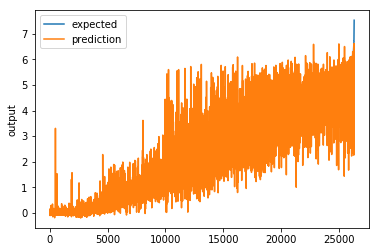

In [18]:
# Plot the chart
chart_regression(pred.flatten(),y_test)

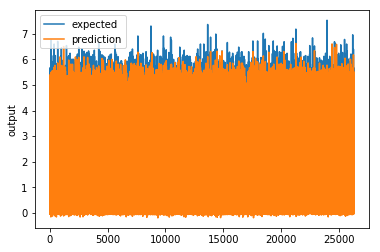

In [19]:
chart_regression(pred.flatten(),y_test,sort=False)

In [20]:
# save entire network to HDF5 (save everything, suggested)
model.save(os.path.join(path,"R7_model.h5"))

In [21]:
# save neural network structure to JSON (no weights)
model_json = model.to_json()
with open(os.path.join(path,"R7_model.json"), "w") as json_file:
    json_file.write(model_json)

In [22]:
# save neural network structure to YAML (no weights)
model_yaml = model.to_yaml()
with open(os.path.join(path,"R7_model.yaml"), "w") as yaml_file:
    yaml_file.write(model_yaml)